In [ ]:
# !pip install pylatexenc
# !pip install qiskit
# !pip install qiskit-aer
# !pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Problem 0

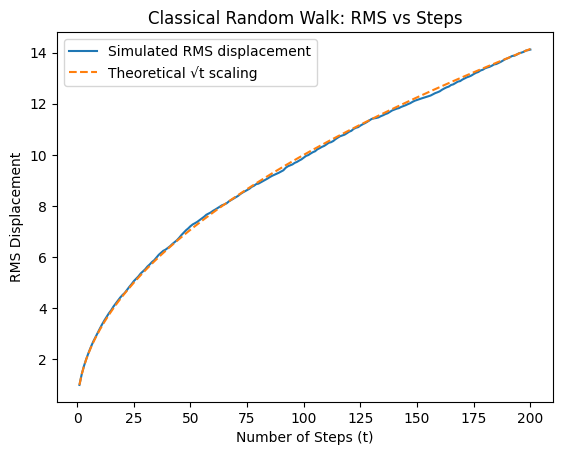

In [3]:
# Parameters
num_walkers = 5000
num_steps = 200

# Simulate random walks
steps = np.random.choice([-1, 1], size=(num_walkers, num_steps))
positions = np.cumsum(steps, axis=1)

# Compute RMS displacement at each time step
rms = np.sqrt(np.mean(positions**2, axis=0))

# Theoretical sqrt(t) scaling
t = np.arange(1, num_steps + 1)
theory = np.sqrt(t)

# Plot
plt.figure()
plt.plot(t, rms, label="Simulated RMS displacement")
plt.plot(t, theory, '--', label="Theoretical √t scaling")

plt.xlabel("Number of Steps (t)")
plt.ylabel("RMS Displacement")
plt.title("Classical Random Walk: RMS vs Steps")
plt.legend()
plt.show()

# Problem 1

In [134]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
def make_increment_gate():
    sub_q = QuantumRegister(3)
    inc = QuantumCircuit(sub_q, name="increment")
    inc.ccx(sub_q[2], sub_q[1], sub_q[0])
    inc.cx(sub_q[2], sub_q[1])
    inc.x(sub_q[2])
    return inc.to_gate(label="INC").control(1)

def make_decrement_gate():
    sub_q = QuantumRegister(3)
    dec = QuantumCircuit(sub_q, name="decrement")
    dec.x(sub_q[1])
    dec.x(sub_q[2])
    dec.ccx(sub_q[2], sub_q[1], sub_q[0])
    dec.x(sub_q[1])
    dec.x(sub_q[2])
    dec.x(sub_q[2])
    dec.cx(sub_q[2], sub_q[1])
    dec.x(sub_q[2])
    dec.x(sub_q[2])
    return dec.to_gate(label="DEC").control(1)
def walk_step_x(qc, coin, pos, inc_gate, dec_gate):
    # coin: 1 qubit
    # pos: list/tuple of 3 qubits (LSB -> MSB)
    
    qc.x(coin)                    # put coin in superposition
    qc.append(inc_gate, [coin] + list(pos))
    
    qc.x(coin)                    # flip coin to enable decrement on |0>
    qc.append(dec_gate, [coin] + list(pos))
    qc.x(coin)  
def make_random_walk_x(num_steps=1):
    # main circuit registers
    pos = QuantumRegister(3, name="pos")
    coin = QuantumRegister(1, name="coin")
    cr = ClassicalRegister(3, name="out")
    qc = QuantumCircuit(pos, coin, cr)

    # build controlled gates
    inc = make_increment_gate()
    dec = make_decrement_gate()

    # perform N steps
    for _ in range(num_steps):
        walk_step_x(qc, coin[0], pos, inc, dec)

    # final measurement
    qc.measure(pos, cr)
    return qc
qc = make_random_walk_x(num_steps=5)

In [135]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.transpiler import generate_preset_pass_manager
sim = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=sim)
qc_optimized = pass_manager.run(qc)
qc_compiled = transpile(qc_optimized, sim)

job = sim.run(qc_compiled, shots=2000)
result = job.result()
counts = result.get_counts()
print(counts)

{'100': 2000}


# Problem 2

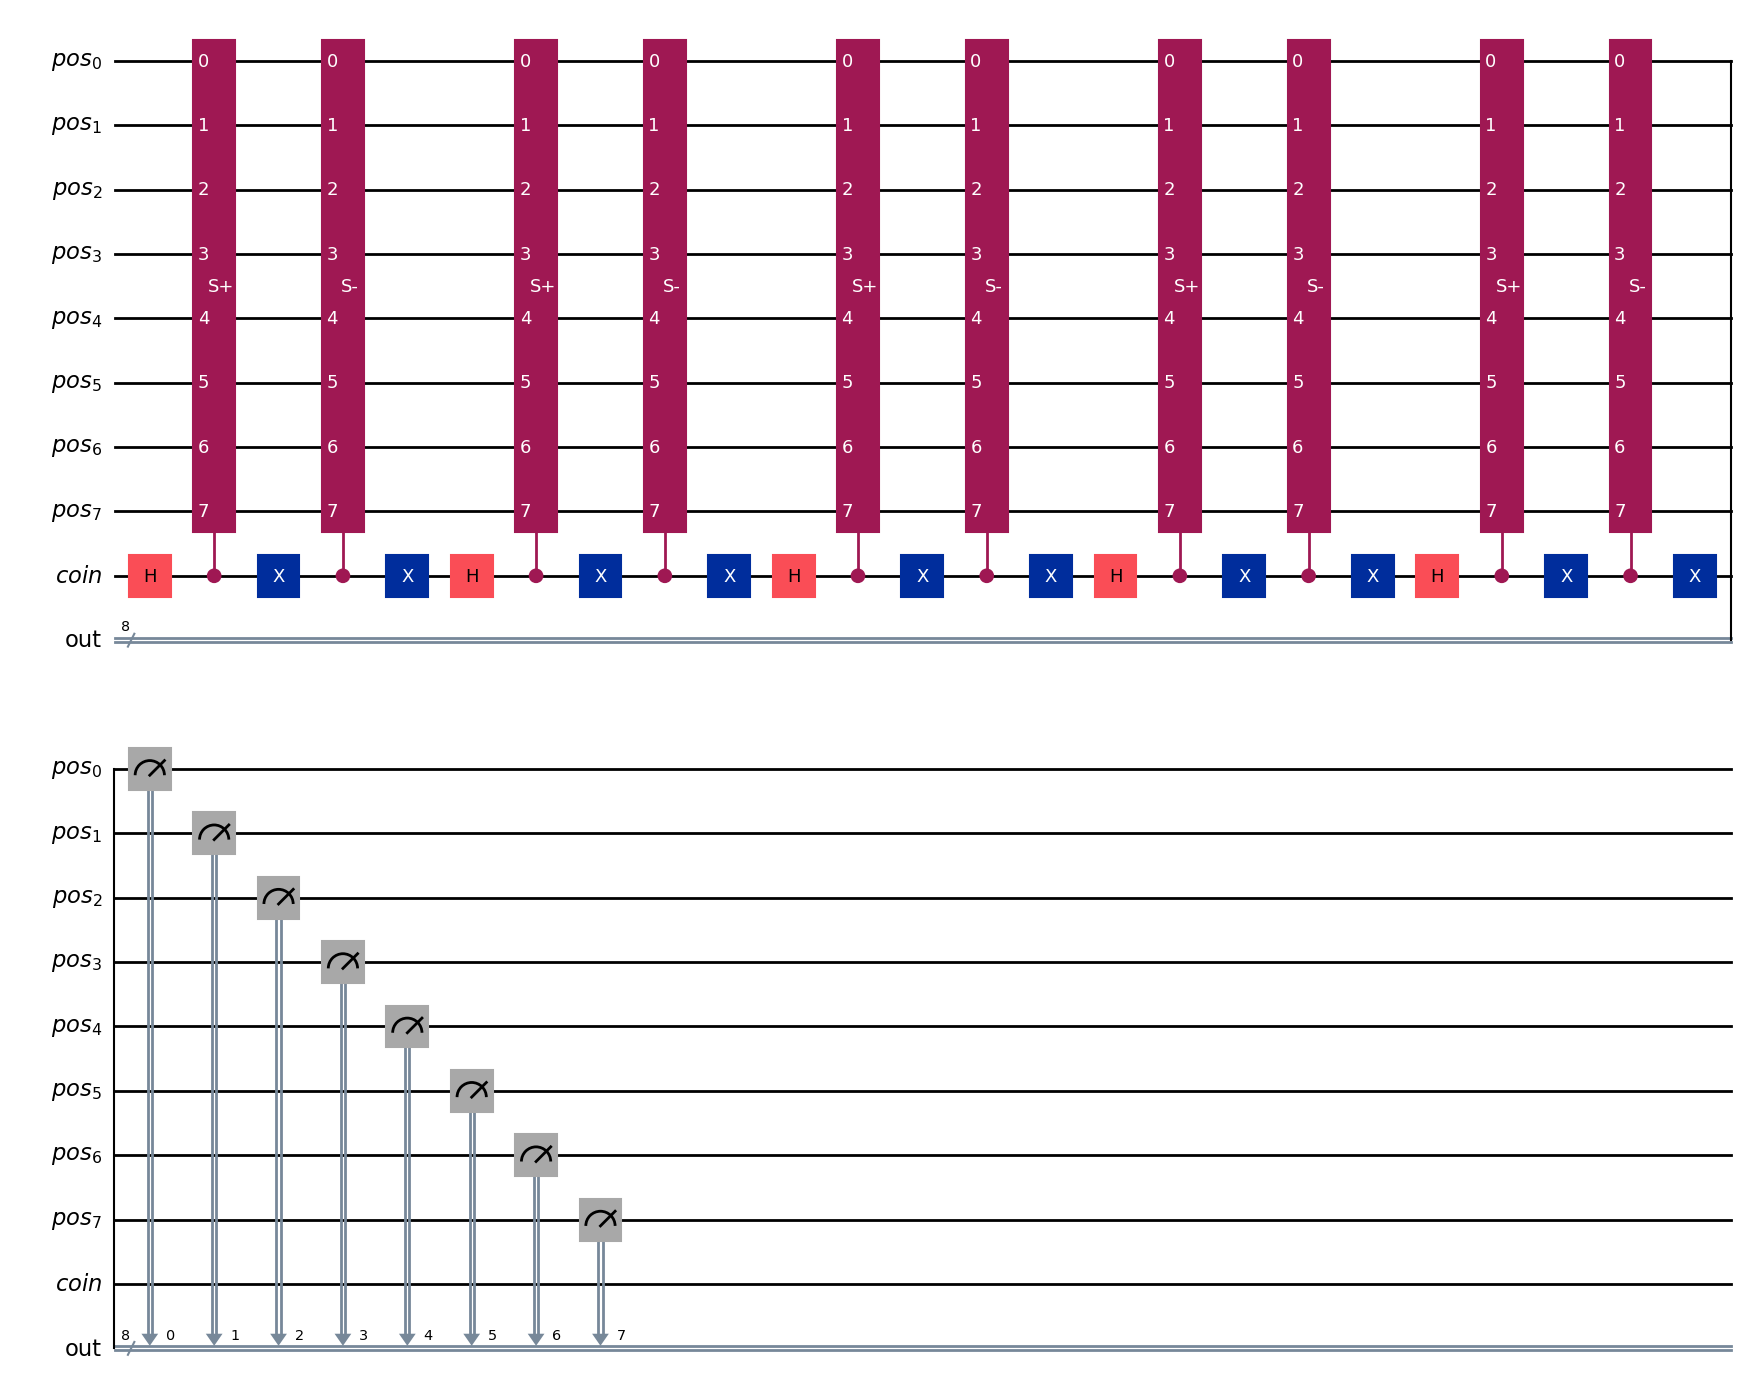

In [153]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def shift_plus(n):
    qr = QuantumRegister(n)
    qc = QuantumCircuit(qr, name="S+")
    
    # Ripple-carry increment
    for i in range(n):
        if i == 0:
            qc.x(0)  # Always flip LSB
        else:
            # Flip qubit i if all LOWER qubits are |1⟩
            qc.mcx(list(range(i)), i)  # Controls: [0, 1, ..., i-1]
    
    return qc.to_gate(label="S+")

def shift_minus(n):
    qr = QuantumRegister(n)
    qc = QuantumCircuit(qr, name="S-")
    
    qc.x(range(n))           # Flip all bits
    
    # Apply increment (same as S+)
    for i in range(n):
        if i == 0:
            qc.x(0)
        else:
            qc.mcx(list(range(i)), i)
    
    qc.x(range(n))           # Flip all bits back
    
    return qc.to_gate(label="S-")

def walk_step_true(qc, coin, pos, s_plus, s_minus):
    qc.h(coin)  # Hadamard coin

    # Controlled on coin=|1⟩ → S+
    qc.append(s_plus.control(1), [coin] + list(pos))
    # Controlled on coin=|0⟩ → S-
    qc.x(coin)
    qc.append(s_minus.control(1), [coin] + list(pos))
    qc.x(coin)  # restore coin
    # 🟢 No further sequential calls — single coherent superposition

def make_quantum_walk(num_steps=1, n_pos=5):
    pos = QuantumRegister(n_pos, "pos")
    coin = QuantumRegister(1, "coin")
    cr = ClassicalRegister(n_pos, "out")
    qc = QuantumCircuit(pos, coin, cr)

    s_plus = shift_plus(n_pos)
    s_minus = shift_minus(n_pos)

    for _ in range(num_steps):
        walk_step_true(qc, coin[0], pos, s_plus, s_minus)

    qc.measure(pos, cr)
    return qc


# Test
qch = make_random_walk_h(num_steps=5, n_pos=8)
qch.draw('mpl')


In [154]:
qch_optimized = pass_manager.run(qch)
qch_compiled = transpile(qch_optimized, sim)

job1 = sim.run(qch_compiled, shots=2000)
result1 = job1.result()
counts1 = result1.get_counts()
fixed_counts1 = {}
for bitstring, count in counts1.items():
    fixed_counts1[bitstring[::-1]] = count  # reverse bitstring

print(fixed_counts1)

{'11011111': 59, '10100000': 62, '11111111': 244, '10000000': 236, '10111111': 345, '11000000': 1054}


In [155]:
rw_circuits=[]
rw_circuits = [make_random_walk_h(num_steps=t) for t in [1,2,3]]
rw_optimized = pass_manager.run(rw_circuits)
rw_compiled = transpile(rw_optimized, sim)
job = sim.run(rw_compiled, shots=2000)
results = job.result()
rw_counts = []
for result_index in range(len(rw_circuits)):
    counts = results.get_counts(result_index)
    # Fix bit order so pos bits appear LSB→MSB
    fixed_counts = {b[::-1]: c for b, c in counts.items()}
    rw_counts.append(fixed_counts)

# Print nicely
for t, cnt in zip([1,2,3], rw_counts):
    print(f"t = {t}: {cnt}")



    


t = 1: {'100': 1004, '111': 996}
t = 2: {'011': 501, '000': 996, '010': 503}
t = 3: {'101': 263, '111': 253, '110': 223, '100': 1261}


In [165]:
def to_signed(bit):
    v = int(bit, 2)
    return v - 8 if v >= 4 else v   # correct two’s complement for 3 position qubits

def rms_from_counts(counts):
    total = sum(counts.values())
    s = 0
    for b, c in counts.items():
        x = to_signed(b)           # convert bitstring → signed position
        s += (x**2) * (c/total)    # accumulate probability * x^2
    return np.sqrt(s)

t_values = [1, 2, 3]

for t, counts in zip(t_values, rw_counts):
    
    rms_q = rms_from_counts(counts)
    rms_c = np.sqrt(t)
    print(f"t = {t}: RMS_quantum = {rms_q:.4f}, classical √t = {rms_c:.4f}")


t = 1: RMS_quantum = 1.0000, classical √t = 1.0000
t = 2: RMS_quantum = 1.8057, classical √t = 1.4142
t = 3: RMS_quantum = 3.4415, classical √t = 1.7321


# Problem 3

In [10]:
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import UnitaryGate
import math
from collections import defaultdict

In [11]:
def build_arc_index(adj):
    """
    Directed arcs: (v, i) means 'from vertex v along its i-th neighbor'.
    Returns:
      arc_index: dict (v,i) -> flat arc id in [0..D-1]
      index_to_arc: list of (v,i)
      neighbor_table: dict (v,i) -> u (the neighbor vertex reached)
      deg: dict v -> degree(v)
    """
    arc_index, index_to_arc, neighbor_table = {}, [], {}
    deg = {v: len(nbrs) for v, nbrs in adj.items()}
    k = 0
    for v, nbrs in adj.items():
        for i, u in enumerate(nbrs):
            arc_index[(v, i)] = k
            index_to_arc.append((v, i))
            neighbor_table[(v, i)] = u
            k += 1
    return arc_index, index_to_arc, neighbor_table, deg

In [12]:
def build_grover_coin(adj, arc_index, deg):
    D = len(arc_index)
    C = np.zeros((D, D), dtype=complex)
    for v, d in deg.items():
        G = 2*np.ones((d,d),dtype=complex)/d - np.eye(d)
        for i in range(d):
            for j in range(d):
                C[arc_index[(v,i)], arc_index[(v,j)]] = G[i,j]
    return C
def build_flipflop_shift(adj, arc_index, neighbor_table):
    D = len(arc_index)
    S = np.zeros((D, D), dtype=complex)
    reverse_index = {}
    for u, nbrs in adj.items():
        for j, w in enumerate(nbrs):
            reverse_index[(w,u)] = (u,j)

    for (v,i), idx in arc_index.items():
        u = neighbor_table[(v,i)]
        (u2,j) = reverse_index[(v,u)]
        S[arc_index[(u,j)], idx] = 1
    return S
def build_step_unitary(adj, arc_index, neighbor_table, deg):
    C = build_grover_coin(adj, arc_index, deg)
    S = build_flipflop_shift(adj, arc_index, neighbor_table)
    U = S @ C
    return U
def embed_unitary(U):
    D = U.shape[0]
    m = math.ceil(math.log2(D))
    dim = 2**m

    U_full = np.eye(dim, dtype=complex)
    U_full[:D, :D] = U
    return U_full, m

In [13]:
def initial_state_vector(arc_index, deg, start_vertex):
    D = len(arc_index)
    psi = np.zeros(D, dtype=complex)
    d0 = deg[start_vertex]
    amp = 1/np.sqrt(d0)

    for i in range(d0):
        psi[arc_index[(start_vertex, i)]] = amp

    return psi
def embed_state_vector(psi, m):
    dim = 2**m
    state = np.zeros(dim, dtype=complex)
    state[:len(psi)] = psi
    return state


In [14]:
def build_walk_circuit(adj, start_vertex, T):
    arc_index, index_to_arc, neighbor_table, deg = build_arc_index(adj)
    
    U = build_step_unitary(adj, arc_index, neighbor_table, deg)
    U_full, m = embed_unitary(U)

    psi_arc = initial_state_vector(arc_index, deg, start_vertex)
    psi_full = embed_state_vector(psi_arc, m)

    # quantum + classical registers
    qc = QuantumCircuit(m, m)        # <-- add m classical bits
    qc.initialize(psi_full, range(m))

    U_gate = UnitaryGate(U_full, label="U_step")
    for _ in range(T):
        qc.append(U_gate, range(m))

    # measurement
    qc.measure(range(m), range(m))    # <-- measure qubits into classical bits

    return qc, index_to_arc
def counts_to_vertex_probs(counts, index_to_arc):
    arc_to_vertex = {k: v for k, (v,i) in enumerate(index_to_arc)}
    
    total = sum(counts.values())
    probs = defaultdict(float)
    
    for bitstr, c in counts.items():
        k = int(bitstr, 2)
        if k < len(index_to_arc):
            probs[arc_to_vertex[k]] += c / total
    
    return dict(probs)

In [170]:
adj_2d = {
0:[1,2,4],
1:[0,3,5],
2:[0,3,6],
3:[1,2,7],
4:[0,5,6],
5:[1,4,7],
6:[2,4,7],
7:[3,5,6]
}
adj_cycle={v: [(v-1) % 8, (v+1)% 8] for v in range(8)}
adj_hypercube = {v: [v ^ (1 << bit) for bit in range(3)] for v in range(1 << 3)}


qc_2d, index_to_arc_2d= build_walk_circuit(adj_2d, start_vertex=0, T=6)
qc_cycle, index_to_arc_cycle= build_walk_circuit(adj_cycle, start_vertex=0, T=6)
qc_hypercube, index_to_arc_hypercube= build_walk_circuit(adj_hypercube, start_vertex=0, T=6)
qc_test=[qc_2d,qc_cycle,qc_hypercube]
index_to_arc_test=[index_to_arc_2d,index_to_arc_cycle,index_to_arc_hypercube]
qc_test = [qc_2d, qc_cycle, qc_hypercube]
index_to_arc_test = [index_to_arc_2d, index_to_arc_cycle, index_to_arc_hypercube]

for qc, index_to_arc in zip(qc_test, index_to_arc_test):
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=4096).result()
    vprobs = counts_to_vertex_probs(result.get_counts(), index_to_arc)
    print(vprobs)

{3: 0.226318359375, 6: 0.219970703125, 0: 0.335205078125, 5: 0.218505859375}
{6: 0.501953125, 2: 0.498046875}
{3: 0.21484375, 5: 0.222900390625, 6: 0.20751953125, 0: 0.354736328125}


# Problem 4

In [16]:
def hadamard_coin():
    return (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)

def coin(theta=np.pi/4):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, s],
                     [s,-c]], dtype=complex)

In [17]:
def phase_potential_diag(N, alpha=0.0, kind=None):
    # returns length-(N+1) vector of phases exp(i*phi(n))
    n = np.arange(N+1)
    if kind is None:
        phi = np.zeros_like(n, dtype=float)
    elif kind == 'linear':
        phi = alpha * n
    elif kind == 'quadratic':
        phi = alpha * (n**2)
    else:
        raise ValueError("phase_kind must be None|'linear'|'quadratic'")
    return np.exp(1j*phi)

In [18]:
def build_step_unitary_osc(N, C=None, alpha=0.0, phase_kind=None):
    if C is None:
        C = hadamard_coin()

    d_osc = N+1
    D = 2*d_osc  # total logical states
    I_osc = np.eye(d_osc, dtype=complex)

    # (C ⊗ I)
    pre = np.kron(C, I_osc)

    # --- Reflecting flip-flop shift (PERMUTATION MATRIX) ---
    S = np.zeros((D, D), dtype=complex)

    def idx(q, n):
        return q*d_osc + n

    for n in range(d_osc):
        # coin = 0 (UP direction)
        if n < N:
            S[idx(0, n+1), idx(0, n)] = 1.0
        else:  # n == N → bounce
            S[idx(1, N), idx(0, N)] = 1.0

        # coin = 1 (DOWN direction)
        if n > 0:
            S[idx(1, n-1), idx(1, n)] = 1.0
        else:  # n == 0 → bounce
            S[idx(0, 0), idx(1, 0)] = 1.0

    # --- Optional diagonal phase U_V ---
    if phase_kind is None:
        U = S @ pre
    else:
        phases = phase_potential_diag(N, alpha=alpha, kind=phase_kind)
        U_V = np.diag(np.concatenate([phases, phases]))  # apply same potential for both coin blocks
        U = S @ (U_V@ pre)

    return U


In [19]:
def embed_unitary_to_power_of_two(U):
    D = U.shape[0]
    m = math.ceil(math.log2(D))
    dim = 2**m
    U_full = np.eye(dim, dtype=complex)
    U_full[:D, :D] = U
    return UnitaryGate(U_full, label="U_step"), m, D


In [20]:
def oscillator_walk_circuit(N, T, C=None, alpha=0.0, phase_kind=None, coin_init=np.array([1,0], dtype=complex), measure=False):
    U = build_step_unitary_osc(N, C=C, alpha=alpha, phase_kind=phase_kind)
    U_gate, m, D = embed_unitary_to_power_of_two(U)

    # Prepare initial logical state vector |coin_init>⊗|n=0>
    psi = np.zeros(D, dtype=complex)
    # indices: [ |0,0>, |0,1>,...,|0,N>, |1,0>,...,|1,N> ]
    psi[0] = coin_init[0]              # |0,0>
    psi[(N+1) + 0] = coin_init[1]      # |1,0>

    # Embed init to 2^m
    full_dim = 2**m
    state0 = np.zeros(full_dim, dtype=complex)
    state0[:D] = psi

    qc = QuantumCircuit(m, m if measure else 0)
    qc.initialize(state0, range(m))
    for _ in range(T):
        qc.append(U_gate, range(m))
    if measure:
        qc.measure(range(m), range(m))
    return qc, m, D

In [21]:
N = 10
T = 3

qc, m, D = oscillator_walk_circuit(N, T, C=hadamard_coin(), phase_kind=None, measure=False)

from qiskit.quantum_info import Statevector
sv = Statevector.from_instruction(qc)

amp0 = sv.data[0:(N+1)]
amp1 = sv.data[(N+1):2*(N+1)]
Pn = np.abs(amp0)**2 + np.abs(amp1)**2

print("Sum P(n) =", float(Pn.sum()))
print({n: float(Pn[n]) for n in range(N+1) if Pn[n] > 1e-12})

Sum P(n) = 0.9999999999999997
{0: 0.12499999999999994, 1: 0.6249999999999998, 2: 0.12499999999999994, 3: 0.12499999999999994}


In [22]:
def probability_distribution_from_statevector(sv, N):
    amp0 = sv.data[0:(N+1)]                 # coin=0 block
    amp1 = sv.data[(N+1):2*(N+1)]           # coin=1 block
    Pn = np.abs(amp0)**2 + np.abs(amp1)**2  # marginalize over coin
    return Pn

def rms_from_Pn(Pn):
    n = np.arange(len(Pn))
    return np.sqrt(np.sum((n**2) * Pn))

# -------- PARAMETERS --------
N = 10                 # oscillator cutoff
C = hadamard_coin()    # coin operator
for t in [1, 2, 3]:
    qc, m, D = oscillator_walk_circuit(N, t, C=C, phase_kind=None, measure=False)
    sv = Statevector.from_instruction(qc)
    Pn = probability_distribution_from_statevector(sv, N)
    rms = rms_from_Pn(Pn)

    # Print results
    support = np.where(Pn > 1e-12)[0]
    print(f"\nt = {t}")
    print(f"P(n,t) (nonzero only):")
    print({int(n): float(Pn[n]) for n in support})
    print(f"RMS(t) = {rms:.4f},     classical sqrt(t) = {np.sqrt(t):.4f}")


t = 1
P(n,t) (nonzero only):
{0: 0.4999999999999999, 1: 0.4999999999999999}
RMS(t) = 0.7071,     classical sqrt(t) = 1.0000

t = 2
P(n,t) (nonzero only):
{0: 0.4999999999999998, 1: 0.2499999999999999, 2: 0.2499999999999999}
RMS(t) = 1.1180,     classical sqrt(t) = 1.4142

t = 3
P(n,t) (nonzero only):
{0: 0.12499999999999994, 1: 0.6249999999999998, 2: 0.12499999999999994, 3: 0.12499999999999994}
RMS(t) = 1.5000,     classical sqrt(t) = 1.7321


In [23]:
C_phase = hadamard_coin()
n_phase = 10
alpha_phase = np.pi/4
phase_type = "quadratic"
for step in [1, 2, 3]:
    
    qc_phase, num_qubits_phase, dim_phase = oscillator_walk_circuit(
        n_phase,
        step,
        C=C_phase,
        alpha=alpha_phase,
        phase_kind=phase_type,
        measure=False
    )

    sv_phase = Statevector.from_instruction(qc_phase)

    amp0 = sv_phase.data[0:(n_phase+1)]
    amp1 = sv_phase.data[(n_phase+1):2*(n_phase+1)]
    P_phase = np.abs(amp0)**2 + np.abs(amp1)**2

    n_vals = np.arange(len(P_phase))
    rms_phase = np.sqrt(np.sum((n_vals**2) * P_phase))

    support = np.where(P_phase > 1e-12)[0]
    P_show_phase = {int(n): float(P_phase[n]) for n in support}

    print(f"\nstep = {step}   phase = {phase_type}, α = {alpha_phase}")
    print("P(n):", P_show_phase)
    print(f"RMS = {rms_phase:.4f},   sqrt(step) = {np.sqrt(step):.4f}")


step = 1   phase = quadratic, α = 0.7853981633974483
P(n): {0: 0.4999999999999999, 1: 0.4999999999999999}
RMS = 0.7071,   sqrt(step) = 1.0000

step = 2   phase = quadratic, α = 0.7853981633974483
P(n): {0: 0.49999999999999983, 1: 0.2499999999999999, 2: 0.24999999999999994}
RMS = 1.1180,   sqrt(step) = 1.4142

step = 3   phase = quadratic, α = 0.7853981633974483
P(n): {0: 0.19822330470336297, 1: 0.5517766952966365, 2: 0.1249999999999999, 3: 0.12499999999999994}
RMS = 1.4754,   sqrt(step) = 1.7321


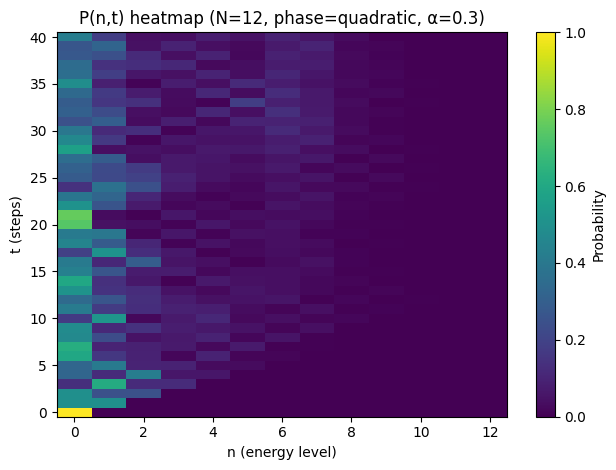

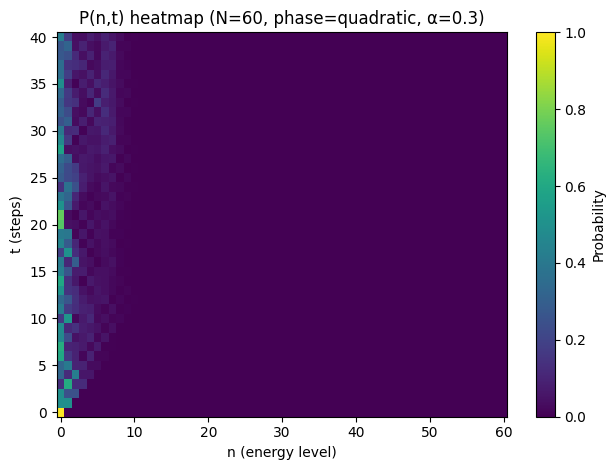

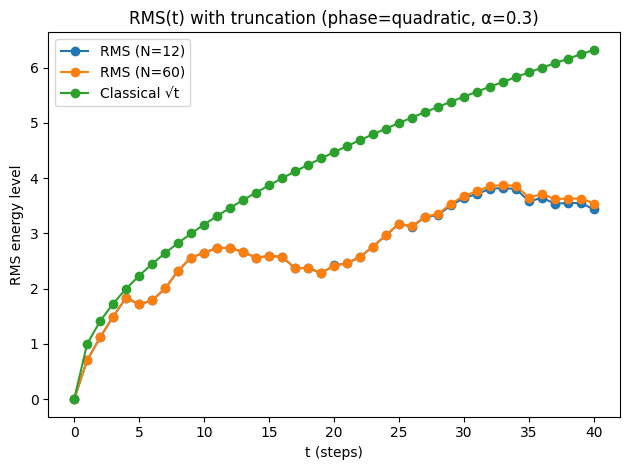

In [24]:
def oscillator_history(N, T_max, C=None, phase_kind=None, alpha=0.0, coin_init=np.array([1,0], dtype=complex)):
    """
    Returns history[t, n] = P(n, t) for t=0..T_max and n=0..N (marginal over coin).
    Uses reflecting flip-flop shift from build_step_unitary_osc.
    """
    U = build_step_unitary_osc(N, C=C, alpha=alpha, phase_kind=phase_kind)
    d = N + 1
    D = 2 * d

    # |coin_init> ⊗ |n=0>
    psi = np.zeros(D, dtype=complex)
    psi[0] = coin_init[0]           # |0,0>
    psi[d + 0] = coin_init[1]       # |1,0>

    hist = np.zeros((T_max + 1, d), dtype=float)
    for t in range(T_max + 1):
        # marginalize over coin
        amp0 = psi[0:d]
        amp1 = psi[d:2*d]
        hist[t] = (np.abs(amp0)**2 + np.abs(amp1)**2).real
        if t < T_max:
            psi = U @ psi
    return hist

def plot_heatmap(history, title="P(n,t) heatmap"):
    """
    history: array shape (T+1, N+1), rows = time t, cols = n.
    """
    plt.figure()
    plt.imshow(history, aspect='auto', origin='lower')
    plt.xlabel('n (energy level)')
    plt.ylabel('t (steps)')
    plt.title(title)
    plt.colorbar(label='Probability')
    plt.tight_layout()
    plt.show()

def rms_from_history(history):
    """
    RMS(t) = sqrt( sum_n n^2 P(n,t) ), returned for all t.
    """
    t_len, d = history.shape
    n = np.arange(d)
    return np.sqrt((history * (n**2)).sum(axis=1))

# -----------------------
# Example usage (EDIT ONLY PARAMS BELOW)
# -----------------------

# reuse your coin and choose phase
C_bonus     = hadamard_coin()   # reuse
phase_bonus = "quadratic"       # 'linear' | 'quadratic' | None
alpha_bonus = 0.3               # tweak phase strength

# small vs large truncation to see boundary reflections/localization
N_small, N_large = 12, 60
T_bonus = 40                    # total steps to visualize

# Run histories
hist_small = oscillator_history(N_small, T_bonus, C=C_bonus, phase_kind=phase_bonus, alpha=alpha_bonus)
hist_large = oscillator_history(N_large, T_bonus, C=C_bonus, phase_kind=phase_bonus, alpha=alpha_bonus)

# Plot heatmaps
plot_heatmap(hist_small, title=f"P(n,t) heatmap (N={N_small}, phase={phase_bonus}, α={alpha_bonus})")
plot_heatmap(hist_large, title=f"P(n,t) heatmap (N={N_large}, phase={phase_bonus}, α={alpha_bonus})")

# (Optional) compare RMS(t) for small vs large truncation to see boundary effects
rms_small = rms_from_history(hist_small)
rms_large = rms_from_history(hist_large)

plt.figure()
plt.plot(rms_small, marker='o', label=f'RMS (N={N_small})')
plt.plot(rms_large, marker='o', label=f'RMS (N={N_large})')
plt.plot(np.sqrt(np.arange(T_bonus+1)), marker='o', label='Classical √t')
plt.xlabel('t (steps)')
plt.ylabel('RMS energy level')
plt.title(f'RMS(t) with truncation (phase={phase_bonus}, α={alpha_bonus})')
plt.legend()
plt.tight_layout()
plt.show()

# Problem 5

In [25]:
from typing import List, Tuple, Dict
from dataclasses import dataclass
PAULI = {
    'I': np.array([[1,0],[0,1]], dtype=complex),
    'X': np.array([[0,1],[1,0]], dtype=complex),
    'Y': np.array([[0,-1j],[1j,0]], dtype=complex),
    'Z': np.array([[1,0],[0,-1]], dtype=complex),
}
PAULI_KEYS = ('X','Y','Z')

def ket_from_abcd(a,b,c,d):
    v = np.array([a,b,c,d], dtype=complex)
    nrm = np.linalg.norm(v)
    if nrm == 0:
        raise ValueError("Zero vector in input.")
    return v / nrm

def rho_from_ket(psi):
    return np.outer(psi, np.conjugate(psi))

In [26]:
def projector_eigs_and_outcomes(basis: str):
    """
    Return (evals, projectors) for Pauli basis X/Y/Z.
    evals: array of eigenvalues (-1, +1)
    projectors: array of shape (2,2,2) where projectors[i] = |e_i><e_i|
    """
    P = PAULI[basis]
    evals, evecs = np.linalg.eigh(P)
    projs = []
    for i in range(2):
        ket = evecs[:, i]
        projs.append(np.outer(ket, ket.conj()))
    projs = np.stack(projs, axis=0)   # shape (2,2,2)
    return evals, projs

def kron(*ops):
    out = np.array([[1]], dtype=complex)
    for op in ops:
        out = np.kron(out, op)
    return out

def sign_of_outcome(basis: str, which: int) -> int:
    """Map eigenprojector index 0/1 to eigenvalue ±1 for basis."""
    evals, _ = projector_eigs_and_outcomes(basis)
    # which is 0 or 1, eigenvalues are (-1,+1) (ordering depends on eigh).
    # Build a consistent mapping: pick the closer to +1 as +1, else -1.
    s = +1 if np.isclose(evals[which], +1.0) else -1
    return s


In [27]:
@dataclass
class ShotRecord:
    b1: str  # basis on qubit 0: 'X'|'Y'|'Z'
    b2: str  # basis on qubit 1
    o1: int  # outcome ±1
    o2: int  # outcome ±1

def sample_product_pauli(psi: np.ndarray, num_shots: int, rng=np.random.default_rng()) -> List[ShotRecord]:
    """
    Randomly pick local bases (X/Y/Z on each qubit), measure in those bases,
    sample outcomes according to Born rule. Return list of ShotRecord.
    """
    shots: List[ShotRecord] = []
    # Precompute projectors for speed
    proj_cache: Dict[str, np.ndarray] = {b: projector_eigs_and_outcomes(b)[1] for b in PAULI_KEYS}
    for _ in range(num_shots):
        b1 = rng.choice(PAULI_KEYS)
        b2 = rng.choice(PAULI_KEYS)
        # projectors: P_b1[0/1] ⊗ P_b2[0/1]
        P1 = proj_cache[b1]  # shape (2,2,2)
        P2 = proj_cache[b2]
        probs = np.zeros((2,2))
        for i in range(2):
            for j in range(2):
                M = kron(P1[i], P2[j])
                probs[i,j] = np.real(np.vdot(psi, M @ psi))
        probs = probs / probs.sum()
        # sample (i,j)
        flat = probs.ravel()
        choice = rng.choice(4, p=flat)
        i, j = divmod(choice, 2)
        o1 = sign_of_outcome(b1, i)
        o2 = sign_of_outcome(b2, j)
        shots.append(ShotRecord(b1, b2, o1, o2))
    return shots

In [28]:
def estimate_pauli_moments(shots: List[ShotRecord]) -> Dict[Tuple[str,str], float]:
    """
    Estimate E[σ_{b1} ⊗ σ_{b2}] for all basis pairs seen in data.
    Also includes single-body moments via ('X','I'), ('I','Y'), etc.
    """
    # Accumulate sums and counts for each pair
    sums: Dict[Tuple[str,str], float] = {}
    cnts: Dict[Tuple[str,str], int] = {}
    # 2-body
    for s in shots:
        key = (s.b1, s.b2)
        sums[key] = sums.get(key, 0.0) + (s.o1 * s.o2)
        cnts[key] = cnts.get(key, 0) + 1
        # singles
        k1 = (s.b1, 'I')
        k2 = ('I', s.b2)
        sums[k1] = sums.get(k1, 0.0) + s.o1
        cnts[k1] = cnts.get(k1, 0) + 1
        sums[k2] = sums.get(k2, 0.0) + s.o2
        cnts[k2] = cnts.get(k2, 0) + 1

    est: Dict[Tuple[str,str], float] = {}
    for k in sums:
        est[k] = sums[k] / max(cnts[k], 1)
    # Also set identity moments to 1.0
    est[('I','I')] = 1.0
    return est

In [29]:
def reconstruct_density_from_moments(est: Dict[Tuple[str,str], float]) -> np.ndarray:
    """
    Use ρ = (1/4) * sum_{a,b in {I,X,Y,Z}} c_{ab} σ_a⊗σ_b .
    We fill c_ab with estimates when available; missing terms default to 0.
    """
    coeff = {('I','I'): 1.0}
    # singles
    for a in PAULI_KEYS:
        coeff[(a,'I')] = est.get((a,'I'), 0.0)
        coeff[('I',a)] = est.get(('I',a), 0.0)
    # correlators
    for a in PAULI_KEYS:
        for b in PAULI_KEYS:
            coeff[(a,b)] = est.get((a,b), 0.0)

    rho = np.zeros((4,4), dtype=complex)
    for A, MA in [('I',PAULI['I'])] + [(k,PAULI[k]) for k in PAULI_KEYS]:
        for B, MB in [('I',PAULI['I'])] + [(k,PAULI[k]) for k in PAULI_KEYS]:
            c = coeff.get((A,B), 0.0)
            rho += c * kron(MA, MB)
    rho = rho / 4.0
    # Hermitize small numerical noise
    rho = 0.5*(rho + rho.conj().T)
    return rho

In [30]:
def project_to_physical_density(rho: np.ndarray) -> np.ndarray:
    """Project to PSD, trace-1 by clipping negative eigenvalues."""
    w, V = np.linalg.eigh(rho)
    w = np.clip(w, 0, None)
    if w.sum() == 0:
        # fallback to maximally mixed
        w = np.array([1,0,0,0], dtype=float)
    rho_psd = (V @ np.diag(w) @ V.conj().T) / w.sum()
    return rho_psd

def best_rank1_pure_state(rho: np.ndarray) -> np.ndarray:
    """Return ket ψ of the leading eigenvector (pure-state projection)."""
    w, V = np.linalg.eigh(rho)
    vec = V[:, np.argmax(w)]
    # fix global phase: make first nonzero component real & ≥ 0
    for k in range(vec.size):
        if np.abs(vec[k]) > 1e-12:
            phase = np.exp(-1j * np.angle(vec[k]))
            vec = vec * phase
            break
    return vec
def fidelity(psi_true: np.ndarray, psi_hat: np.ndarray) -> float:
    return float(np.abs(np.vdot(psi_true, psi_hat))**2)

In [31]:
def parse_complex(s: str) -> complex:
    # Accept forms like "0.2", "0.3+0.4j", "1-0.5i"
    s = s.replace('i','j')
    return complex(s)

def load_tests(path: str) -> List[np.ndarray]:
    """File format:
       number_of_tests
       a b c d
       a b c d
       ...
    """
    out = []
    with open(path, 'r') as f:
        first = f.readline().strip()
        T = int(first)
        for _ in range(T):
            line = f.readline()
            if not line:
                break
            a,b,c,d = [parse_complex(x) for x in line.split()]
            psi = ket_from_abcd(a,b,c,d)
            out.append(psi)
    return out

In [32]:
@dataclass
class EstimationResult:
    psi_hat: np.ndarray
    rho_hat: np.ndarray
    shots: int
    fid: float | None

def estimate_state_from_shots(psi_true: np.ndarray, shots: int = 500, rng=None, return_fidelity=True) -> EstimationResult:
    if rng is None:
        rng = np.random.default_rng()
    # simulate measurements
    recs = sample_product_pauli(psi_true, shots, rng=rng)
    # estimate Pauli moments
    est = estimate_pauli_moments(recs)
    # linear inversion → rho
    rho_lin = reconstruct_density_from_moments(est)
    rho_phys = project_to_physical_density(rho_lin)
    # pure-state projection
    psi_hat = best_rank1_pure_state(rho_phys)
    rho_hat = rho_from_ket(psi_hat)
    fid_val = fidelity(psi_true, psi_hat) if return_fidelity else None
    return EstimationResult(psi_hat=psi_hat, rho_hat=rho_hat, shots=shots, fid=fid_val)

def run_file(path: str, shots: int = 500, seed: int = 7) -> List[EstimationResult]:
    rng = np.random.default_rng(seed)
    tests = load_tests(path)
    results = []
    for psi in tests:
        res = estimate_state_from_shots(psi, shots=shots, rng=rng, return_fidelity=True)
        results.append(res)
    return results

In [33]:
def summarize(results: List[EstimationResult]):
    for i, r in enumerate(results):
        print(f"Test {i+1}: Fidelity = {r.fid:.6f}")

In [34]:
res = run_file("/kaggle/input/statevector-test/state_test_200.txt", shots=500)
summarize(res)


Test 1: Fidelity = 0.986194
Test 2: Fidelity = 0.986869
Test 3: Fidelity = 0.982620
Test 4: Fidelity = 0.993923
Test 5: Fidelity = 0.995882
Test 6: Fidelity = 0.997490
Test 7: Fidelity = 0.989393
Test 8: Fidelity = 0.996459
Test 9: Fidelity = 0.978863
Test 10: Fidelity = 0.992060
Test 11: Fidelity = 0.986029
Test 12: Fidelity = 0.992307
Test 13: Fidelity = 0.986113
Test 14: Fidelity = 0.989549
Test 15: Fidelity = 0.989923
Test 16: Fidelity = 0.976716
Test 17: Fidelity = 0.991076
Test 18: Fidelity = 0.953304
Test 19: Fidelity = 0.980609
Test 20: Fidelity = 0.994780
Test 21: Fidelity = 0.984418
Test 22: Fidelity = 0.994831
Test 23: Fidelity = 0.993273
Test 24: Fidelity = 0.996901
Test 25: Fidelity = 0.984369
Test 26: Fidelity = 0.993803
Test 27: Fidelity = 0.990890
Test 28: Fidelity = 0.995967
Test 29: Fidelity = 0.990466
Test 30: Fidelity = 0.988502
Test 31: Fidelity = 0.984623
Test 32: Fidelity = 0.986742
Test 33: Fidelity = 0.995271
Test 34: Fidelity = 0.983580
Test 35: Fidelity = 0.9

# Problem 6

In [35]:
from numpy.linalg import eigh, norm
from scipy.linalg import expm
zero = np.array([1,0], dtype=complex)
one  = np.array([0,1], dtype=complex)

In [36]:
def ket(*bits):
    v = np.array([1], dtype=complex)
    for b in bits:
        v = np.kron(v, zero if b==0 else one)
    return v  # length 4

I2 = np.eye(2, dtype=complex)
I4 = np.eye(4, dtype=complex)

In [37]:
psi0 = (ket(0,0) + ket(0,1) + ket(1,0) + ket(1,1)) / 2.0

# H0 = I - |psi0><psi0|
H0 = I4 - np.outer(psi0, psi0.conj())

# HP = I - |11><11|
ket11 = ket(1,1)
HP = I4 - np.outer(ket11, ket11.conj())

In [38]:
def H_of_s(s: float) -> np.ndarray:
    """Interpolating Hamiltonian H(s) = (1-s)H0 + s HP."""
    return (1.0 - s) * H0 + s * HP

# dH/ds = HP - H0 (constant in s)
dHds = HP - H0


In [39]:
def scan_spectrum(n_points: int = 200):
    """Return s-grid, eigenvalues (sorted), eigenvectors for each s."""
    s_grid = np.linspace(0.0, 1.0, n_points)
    evals_all = np.zeros((n_points, 4), dtype=float)
    evecs_all = np.zeros((n_points, 4, 4), dtype=complex)
    for k, s in enumerate(s_grid):
        Hs = H_of_s(s)
        w, V = eigh(Hs)                # ascending order
        evals_all[k] = w
        evecs_all[k] = V
    return s_grid, evals_all, evecs_all
def min_gap(evals_all: np.ndarray):
    """Return minimum spectral gap Δ_min between ground (E0) and first excited (E1)."""
    gaps = evals_all[:,1] - evals_all[:,0]
    k = int(np.argmin(gaps))
    return float(gaps[k]), k, gaps

In [40]:
def max_adiabatic_coupling(evecs_all: np.ndarray):
    """
    Return max_s |<E1(s)| dH/ds |E0(s)>| across the scanned s-grid.
    evecs_all[k,:,j] is eigenvector j at s-index k.
    """
    K = evecs_all.shape[0]
    vals = np.zeros(K, dtype=float)
    for k in range(K):
        v0 = evecs_all[k,:,0]  # ground
        v1 = evecs_all[k,:,1]  # first excited
        vals[k] = abs(np.vdot(v1, dHds @ v0))
    i = int(np.argmax(vals))
    return float(vals[i]), i, vals

def adiabatic_runtime_bound(delta_min: float, max_coupling: float, epsilon: float = 0.1):
    """
    Very rough order-of-magnitude bound: T ≳ max_coupling / Δ_min^2 (scaled by 1/epsilon if desired).
    """
    return max_coupling / max(delta_min, 1e-12)**2 / max(epsilon, 1e-12)

In [41]:
def evolve_time_dependent(T: float,
                          n_steps: int,
                          psi_init: np.ndarray = psi0,
                          record_fidelity: bool = True):
    """
    Piecewise-constant propagation with step dt=T/n_steps:
      U_k = exp(-i H(s_k) dt), s_k = k/n_steps
    Returns:
      times, states, (optional) ground-state fidelity over time.
    """
    dt = T / n_steps
    states = np.zeros((n_steps+1, 4), dtype=complex)
    states[0] = psi_init.astype(complex)
    fid = np.zeros(n_steps+1, dtype=float) if record_fidelity else None

    for k in range(n_steps):
        s = k / n_steps
        Hs = H_of_s(s)
        U = expm(-1j * Hs * dt)
        states[k+1] = U @ states[k]

        if record_fidelity:
            # instantaneous ground state at s (eigenvector with min eigenvalue)
            w, V = eigh(Hs)
            v0 = V[:, 0]
            fid[k] = abs(np.vdot(v0, states[k]))**2
    if record_fidelity:
        # final point fidelity against ground of H(1)
        w, V = eigh(H_of_s(1.0))
        v0 = V[:, 0]
        fid[-1] = abs(np.vdot(v0, states[-1]))**2
    return np.linspace(0.0, T, n_steps+1), states, fid

In [42]:
def success_probability(psi: np.ndarray) -> float:
    """Probability of measuring |11> at the end: ⟨ψ| (|11><11|) |ψ⟩."""
    return float(abs(np.vdot(ket11, psi))**2)

def final_success_vs_T(T_list, n_steps_per_T: int = 200):
    """
    Sweep T, evolve, and return arrays of:
      success_prob(T) and final ground-state fidelity.
    """
    succ = []
    gs_fid = []
    for T in T_list:
        _, states, fid = evolve_time_dependent(T, n_steps_per_T, psi_init=psi0, record_fidelity=True)
        succ.append(success_probability(states[-1]))
        gs_fid.append(fid[-1])
    return np.array(succ), np.array(gs_fid)

In [43]:
def plot_spectrum(s_grid, evals_all, *, ax=None, title="Instantaneous eigenvalues vs s"):
    import matplotlib.pyplot as plt
    if ax is None:
        fig, ax = plt.subplots()
    for j in range(evals_all.shape[1]):
        ax.plot(s_grid, evals_all[:, j], label=f"E{j}")
    ax.set_xlabel("s")
    ax.set_ylabel("Eigenvalue")
    ax.set_title(title)
    ax.legend()
    return ax

def plot_gap(s_grid, gaps, *, ax=None, title="Spectral gap Δ(s)"):
    import matplotlib.pyplot as plt
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(s_grid, gaps)
    ax.set_xlabel("s")
    ax.set_ylabel("Δ(s) = E1 - E0")
    ax.set_title(title)
    return ax

def plot_ground_fidelity(times, fid, *, ax=None, title="Instantaneous ground-state fidelity"):
    import matplotlib.pyplot as plt
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(times, fid)
    ax.set_xlabel("t")
    ax.set_ylabel("|<E0(s)|ψ(t)>|^2")
    ax.set_title(title)
    return ax

Minimum spectral gap Δ_min ≈ 0.500005 at s ≈ 0.4987


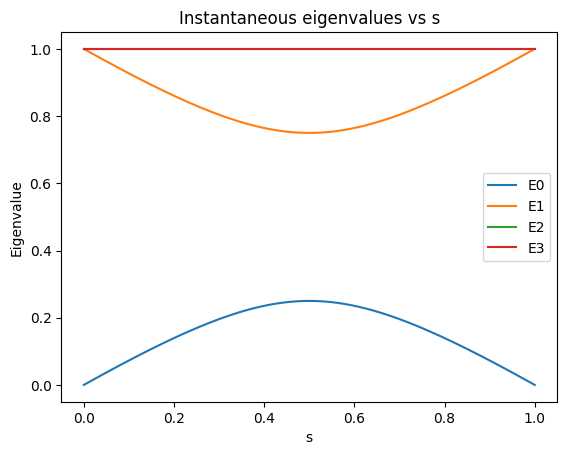

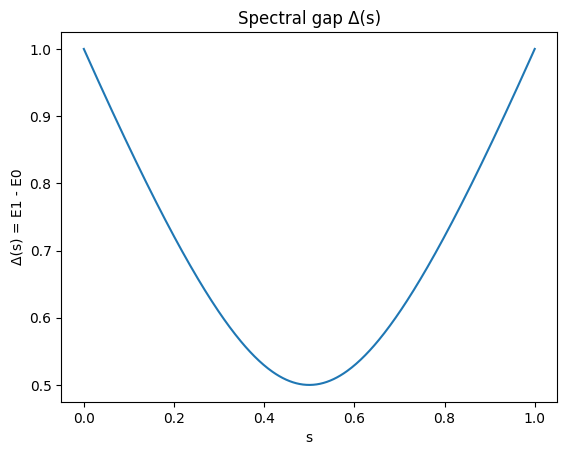

max_s |<E1| dH/ds |E0>| ≈ 0.866017
Estimated adiabatic runtime T >> 34.64


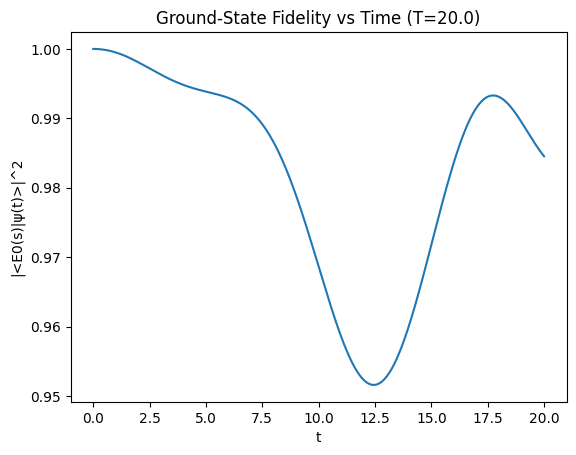

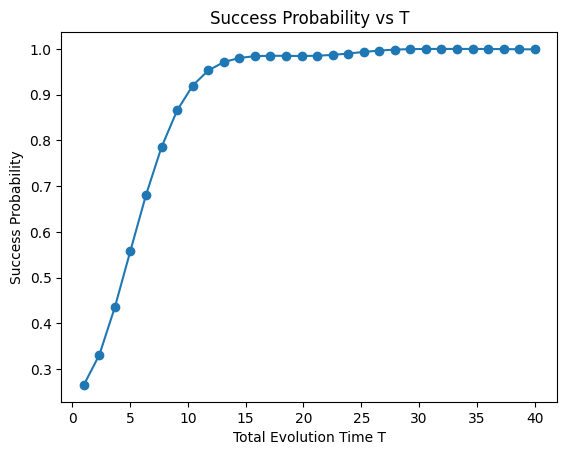

In [44]:
# 1) Compute spectrum and gap
s_grid, evals_all, evecs_all = scan_spectrum(400)
Δ_min, idx_min, gaps = min_gap(evals_all)

print(f"Minimum spectral gap Δ_min ≈ {Δ_min:.6f} at s ≈ {s_grid[idx_min]:.4f}")

# Plot eigenvalues
plot_spectrum(s_grid, evals_all)
plt.show()

# Plot spectral gap
plot_gap(s_grid, gaps)
plt.show()


# 2) Adiabatic runtime bound
max_cpl, idx_cpl, vals = max_adiabatic_coupling(evecs_all)
T_est = adiabatic_runtime_bound(Δ_min, max_cpl)
print(f"max_s |<E1| dH/ds |E0>| ≈ {max_cpl:.6f}")
print(f"Estimated adiabatic runtime T >> {T_est:.2f}")


# 3) Time evolution for a moderately large T
T = 20.0    # try also T = 5, 50
times, states, fidelity_vs_t = evolve_time_dependent(T, n_steps=600)

plot_ground_fidelity(times, fidelity_vs_t)
plt.title(f"Ground-State Fidelity vs Time (T={T})")
plt.show()


# 4) Success probability scaling
T_list = np.linspace(1, 40, 30)
succ, gs_fid = final_success_vs_T(T_list)

plt.figure()
plt.plot(T_list, succ, 'o-')
plt.xlabel("Total Evolution Time T")
plt.ylabel("Success Probability")
plt.title("Success Probability vs T")
plt.show()


# Problem 7


In [45]:
import itertools
from scipy.optimize import minimize
# Pauli matrices
X = np.array([[0,1],[1,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)
I = np.eye(2, dtype=complex)

def kron(*ops):
    out = ops[0]
    for op in ops[1:]:
        out = np.kron(out, op)
    return out

# Build MaxCut Hamiltonian on triangle
I3 = kron(I, I, I)

HP = 0.5*(I3 - kron(Z, Z, I)) \
   + 0.5*(I3 - kron(I, Z, Z)) \
   + 0.5*(I3 - kron(Z, I, Z))

HM = kron(X, I, I) + kron(I, X, I) + kron(I, I, X)

# Initial |+>^⊗3 state
plus = (1/np.sqrt(2))*np.array([1,1], dtype=complex)
psi_plus = kron(plus, plus, plus)   # now shape = (8,)



In [46]:
from scipy.optimize import minimize

def expi(H, theta):
    return expm(-1j * theta * H)

def qaoa_state(gammas, betas):
    psi = psi_plus.copy()
    for γ, β in zip(gammas, betas):
        psi = expi(HP, γ) @ psi
        psi = expi(HM, β) @ psi
    return psi

def exp_cost(psi):
    return np.real(np.vdot(psi, HP @ psi))

def qaoa_expectation(p, θ):
    gammas = θ[:p]
    betas  = θ[p:]
    return exp_cost(qaoa_state(gammas, betas))

def optimize_qaoa(p, n_starts=12, seed=7):
    best_val = -1e9
    best_θ = None
    rng = np.random.default_rng(seed)
    for _ in range(n_starts):
        θ0 = rng.uniform(-np.pi, np.pi, size=2*p)
        res = minimize(lambda th: -qaoa_expectation(p, th), θ0,
                       method="Nelder-Mead",
                       options=dict(maxiter=800, xatol=1e-6, fatol=1e-6))
        val = -res.fun
        if val > best_val:
            best_val = val
            best_θ = res.x
    return best_val, best_θ


In [47]:
def trotterized_adiabatic_state(p, T):
    psi = psi_plus.copy()
    Δt = T / p
    for k in range(1, p+1):
        s = k/p
        # U_ad ≈ exp{-i(1-s)Δt HM} exp{-i s Δt HP}  (first-order Trotter)
        psi = expi(HP, s*Δt) @ (expi(HM, (1-s)*Δt) @ psi)
    return psi

def sweep_adiabatic_vs_T(p, T_grid):
    vals = []
    for T in T_grid:
        psi = trotterized_adiabatic_state(p, T)
        vals.append(exp_cost(psi))
    return np.array(vals)

In [50]:
P_list = [1,2,3] 
qaoa_vals, qaoa_params = [], []
for p in P_list: 
    val, θ = optimize_qaoa(p, n_starts=16, seed=1234) 
    qaoa_vals.append(val); qaoa_params.append(θ) 
    print(f"QAOA p={p}: <C> ≈ {val:.6f}") 
T_grid = np.linspace(0.0, 20.0, 81) # scan T 
adia_best = [] 
for p in P_list: 
    vals = sweep_adiabatic_vs_T(p, T_grid) 
    adia_best.append(vals.max()) 
    print(f"Adiabatic (p={p} slices): best over T∈[0,20] <C> ≈ {vals.max():.6f} at T≈{T_grid[np.argmax(vals)]:.2f}")

QAOA p=1: <C> ≈ 2.000000
QAOA p=2: <C> ≈ 2.000000
QAOA p=3: <C> ≈ 2.000000
Adiabatic (p=1 slices): best over T∈[0,20] <C> ≈ 1.500000 at T≈0.25
Adiabatic (p=2 slices): best over T∈[0,20] <C> ≈ 1.500000 at T≈17.00
Adiabatic (p=3 slices): best over T∈[0,20] <C> ≈ 1.920033 at T≈3.50


# Problem 8

In [52]:
from qiskit.circuit.library import RZZGate
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.result import Counts

In [53]:
def qaoa_triangle_circuit(gammas: List[float], betas: List[float]) -> QuantumCircuit:
    assert len(gammas) == len(betas)
    p = len(gammas)
    qc = QuantumCircuit(3)
    qc.h(range(3))
    edges = [(0,1),(1,2),(0,2)]
    for k in range(p):
        γ, β = gammas[k], betas[k]
        # e^{-i γ HP} up to global phase is ∏_edges RZZ(-γ)
        for (i,j) in edges:
            qc.append(RZZGate(-γ), [i,j])
        # e^{-i β HM} = ∏ RX(2β)
        for q in range(3):
            qc.rx(2*β, q)
    return qc


In [54]:
def cost_triangle_from_bitstring(bits: str) -> int:
    # Order: q2 q1 q0 (Qiskit prints msb..lsb); convert to z in {+1,-1}
    z = [1 if b=='0' else -1 for b in bits[::-1]]  # [q0,q1,q2]
    return int(0.5*(1 - z[0]*z[1]) + 0.5*(1 - z[1]*z[2]) + 0.5*(1 - z[2]*z[0]))

def expected_cost_from_counts(counts: Counts) -> float:
    shots = sum(counts.values())
    return sum(cost_triangle_from_bitstring(b)*c for b,c in counts.items())/shots

In [55]:
def trotter_triangle_circuit(p: int, T: float) -> QuantumCircuit:
    qc = QuantumCircuit(3)
    qc.h(range(3))
    edges = [(0,1),(1,2),(0,2)]
    Δt = T/p
    for k in range(1, p+1):
        s = k/p
        # e^{-i s Δt HP}
        for (i,j) in edges:
            qc.append(RZZGate(-s*Δt), [i,j])
        # e^{-i (1-s) Δt HM}
        for q in range(3):
            qc.rx(2*(1-s)*Δt, q)
    return qc


In [56]:
def amp_damp_noise(pAD: float) -> NoiseModel:
    nm = NoiseModel()
    ad = amplitude_damping_error(pAD)
    # Add on all single-qubit basis gates likely present
    for g in ['rx','rz','x','h','id','sx','measure']:
        nm.add_all_qubit_quantum_error(ad, g) if g!='measure' else None
    return nm

In [57]:
def run_counts(circ: QuantumCircuit, shots: int, pAD: float | None = None, seed: int = 1234) -> Counts:
    qc = circ.copy()
    qc.measure_all()
    if pAD is None:
        sim = AerSimulator()
        tqc = transpile(qc, sim)
        return sim.run(tqc, shots=shots, seed_simulator=seed).result().get_counts()
    else:
        sim = AerSimulator(noise_model=amp_damp_noise(pAD), method='density_matrix')
        tqc = transpile(qc, sim, optimization_level=1)
        return sim.run(tqc, shots=shots, seed_simulator=seed).result().get_counts()

In [58]:
def sweep_noise_triangle(
    p_list: List[int],
    shots: int = 5000,
    pAD_grid: np.ndarray = np.linspace(0, 0.3, 7),
    T_for_trotter: float = 6.0,
    n_random_starts: int = 8,
    seed: int = 7,
) -> Dict[str, Dict]:
    rng = np.random.default_rng(seed)
    out = dict(qaoa={}, trotter={})
    # For each depth p, random-search QAOA angles (kept simple here; you can plug your optimizer)
    for p in p_list:
        # quick random pick of best (γ,β)
        best_val, best_pair = -np.inf, None
        for _ in range(n_random_starts):
            gam = rng.uniform(-np.pi, np.pi, size=p)
            bet = rng.uniform(-np.pi, np.pi, size=p)
            counts = run_counts(qaoa_triangle_circuit(gam, bet), shots=4000, pAD=None, seed=seed)
            val = expected_cost_from_counts(counts)
            if val > best_val:
                best_val, best_pair = val, (gam, bet)
        gammas, betas = best_pair
        # record QAOA curve
        q_vals = []
        for pAD in pAD_grid:
            cts = run_counts(qaoa_triangle_circuit(gammas, betas), shots=shots, pAD=pAD, seed=seed+1)
            q_vals.append(expected_cost_from_counts(cts))
        out['qaoa'][p] = dict(pAD=pAD_grid, EC=np.array(q_vals), params=(gammas, betas))
        # record Trotter curve
        t_vals = []
        for pAD in pAD_grid:
            cts = run_counts(trotter_triangle_circuit(p, T_for_trotter), shots=shots, pAD=pAD, seed=seed+2)
            t_vals.append(expected_cost_from_counts(cts))
        out['trotter'][p] = dict(pAD=pAD_grid, EC=np.array(t_vals), T=T_for_trotter)
    return out

In [59]:
import numpy as np

# --- Basic single-qubit gates & CZ ---
H = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
X = np.array([[0,1],[1,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)
CZ = np.diag([1,1,1, -1]).astype(complex)

def kronN(ops: list[np.ndarray]) -> np.ndarray:
    out = np.array([[1]], dtype=complex)
    for op in ops:
        out = np.kron(out, op)
    return out

def apply_two_qubit_unitary(state: np.ndarray, U2: np.ndarray, n: int, i: int, j: int) -> np.ndarray:
    # Apply U2 on sites (i,j) with identity elsewhere
    ops = [np.eye(2, dtype=complex) for _ in range(n)]
    ops[i] = None; ops[j] = None
    # Build by swapping positions: construct full U via kron, place U2 at i,j
    # Simpler: reshape trick
    order = [2]*n
    psi = state.reshape(order)
    # move axes (i,j) to front
    axes = [i, j] + [k for k in range(n) if k not in (i,j)]
    psi = np.transpose(psi, axes)
    psi = psi.reshape(4, -1)
    psi = (U2 @ psi).reshape([2,2] + [2]*(n-2))
    # inverse transpose
    inv_axes = np.argsort(axes)
    psi = np.transpose(psi, inv_axes)
    return psi.reshape(-1)

def random_measure_Z(state: np.ndarray, n: int, q: int, rng: np.random.Generator) -> tuple[np.ndarray, int]:
    # Measure qubit q in Z, return collapsed state and outcome (0/1)
    # Get probability of outcome 0
    dimA = 2**q
    dimB = 2**(n-q-1)
    psi = state.reshape(dimA, 2, dimB)  # index on measured qubit is the middle axis
    p0 = np.linalg.norm(psi[:,0,:])**2
    if p0 < 1 and rng.random() > p0:
        outcome = 1
        ket = psi[:,1,:].ravel()
    else:
        outcome = 0
        ket = psi[:,0,:].ravel()
    # normalize
    ket = ket / max(np.linalg.norm(ket), 1e-16)
    # Reinsert measured axis (fixed to outcome): expand back to size 2^n
    full = np.zeros_like(state)
    # place amplitudes back into the appropriate computational subspace
    # easiest: project with bra ⟨outcome| on axis q
    P = np.array([[1,0],[0,0]], dtype=complex) if outcome==0 else np.array([[0,0],[0,1]], dtype=complex)
    # Build projector operator and renormalize by (p_outcome)^(-1/2)
    # However we already collapsed 'ket'. We can reconstruct by tensoring |outcome> and reshaping:
    ket2 = np.kron(np.kron(np.eye(2**q), np.array([1,0]) if outcome==0 else np.array([0,1])), np.eye(2**(n-q-1)))
    # Apply the embedding operator to fill amplitudes in right slots
    # Use sparse-like scatter via indexing:
    # Rebuild via basis enumeration (compact, okay for moderate n):
    full[:] = 0.0
    idx = 0
    for b in range(2**n):
        if ((b >> q) & 1) == outcome:
            full[b] = ket[idx]; idx += 1
    return full, outcome

def von_neumann_entropy_half(state: np.ndarray, n: int, base: float = 2.0) -> float:
    # bipartition A = first n//2 qubits
    nA = n//2
    dimA, dimB = 2**nA, 2**(n-nA)
    rho = np.outer(state, state.conj())
    rhoA = np.zeros((dimA, dimA), dtype=complex)
    # partial trace over B
    rho = rho.reshape(dimA, dimB, dimA, dimB)
    rhoA = np.einsum('abcb->ac', rho)
    w = np.linalg.eigvalsh(rhoA)
    w = np.clip(np.real(w), 1e-16, 1.0)
    return float(-np.sum(w*np.log(w))/np.log(base))

def simulate_chain_entropy(
    n: int,
    depth: int,
    pm: float,
    gate: str = 'CZ',        # 'CZ' or 'iSWAP'
    n_trajectories: int = 64,
    seed: int = 7,
    reprepare: bool = False  # if True, after measuring Z apply H to reset to |+>
) -> np.ndarray:
    rng = np.random.default_rng(seed)
    # iSWAP unitary if requested
    if gate.lower() == 'iswap':
        ISWAP = np.array([[1,0,0,0],
                          [0,0,1j,0],
                          [0,1j,0,0],
                          [0,0,0,1]], dtype=complex)
        U2 = ISWAP
    else:
        U2 = CZ

    ent = np.zeros((n_trajectories, depth+1))
    for r in range(n_trajectories):
        # |+>^n
        plus = (1/np.sqrt(2))*np.array([1,1], dtype=complex)
        state = kronN([plus]*n)
        ent[r,0] = von_neumann_entropy_half(state, n)
        for t in range(1, depth+1):
            # even bonds: (0,1), (2,3), ...
            for i in range(0, n-1, 2):
                state = apply_two_qubit_unitary(state, U2, n, i, i+1)
            # odd bonds: (1,2), (3,4), ...
            for i in range(1, n-1, 2):
                state = apply_two_qubit_unitary(state, U2, n, i, i+1)
            # random Z measurements with prob pm on each site
            for q in range(n):
                if rng.random() < pm:
                    state, outcome = random_measure_Z(state, n, q, rng)
                    if reprepare:
                        # corrective: X if outcome=1 (|1>→|0>), then H to go back to |+>
                        if outcome == 1:
                            # apply X on site q
                            state = apply_two_qubit_unitary(state, np.kron(X, np.eye(2)), n, q, (q+1)%n) if n>1 else kronN([X])@state
                            # Single-qubit apply shortcut for general n:
                            # safer generic 1q: build op list
                            ops = [np.eye(2,dtype=complex) for _ in range(n)]
                            ops[q] = X
                            state = (kronN(ops) @ state)
                        ops = [np.eye(2,dtype=complex) for _ in range(n)]
                        ops[q] = H
                        state = (kronN(ops) @ state)
            ent[r,t] = von_neumann_entropy_half(state, n)
    return ent.mean(axis=0)   # average S_half[t] over trajectories


In [60]:
 results_noise = sweep_noise_triangle(p_list=[1,2], shots=5000, pAD_grid=np.linspace(0,0.3,7), T_for_trotter=6.0)

In [61]:
S_pm0  = simulate_chain_entropy(n=8, depth=40, pm=0.0,  gate='CZ', n_trajectories=64)
S_pm05 = simulate_chain_entropy(n=8, depth=40, pm=0.5, gate='CZ', n_trajectories=64)


In [63]:
S_adapt = simulate_chain_entropy(n=8, depth=40, pm=0.5, gate='CZ', n_trajectories=64, reprepare=True)

In [65]:
results_noise = sweep_noise_triangle(
    p_list=[1,2],
    shots=5000,
    pAD_grid=np.linspace(0,0.3,7),
    T_for_trotter=6.0
)


In [66]:
qaoa_p1 = results_noise["qaoa"][1]
qaoa_p2 = results_noise["qaoa"][2]
trot_p1 = results_noise["trotter"][1]
trot_p2 = results_noise["trotter"][2]

pAD_grid = qaoa_p1["pAD"]   # same grid for all


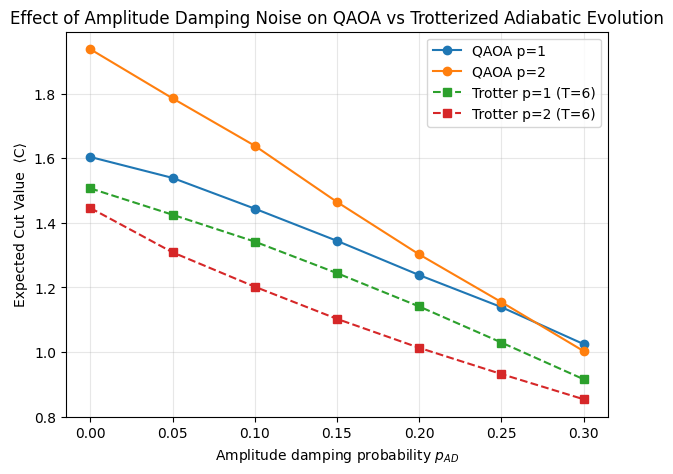

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

plt.plot(pAD_grid, qaoa_p1["EC"], 'o-', label="QAOA p=1")
plt.plot(pAD_grid, qaoa_p2["EC"], 'o-', label="QAOA p=2")

plt.plot(pAD_grid, trot_p1["EC"], 's--', label="Trotter p=1 (T=6)")
plt.plot(pAD_grid, trot_p2["EC"], 's--', label="Trotter p=2 (T=6)")

plt.xlabel("Amplitude damping probability $p_{AD}$")
plt.ylabel("Expected Cut Value  ⟨C⟩")
plt.title("Effect of Amplitude Damping Noise on QAOA vs Trotterized Adiabatic Evolution")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [70]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Basic utilities -----
def kron_state(*kets):
    """Tensor product for state vectors (returns 1D vector)."""
    psi = kets[0]
    for k in kets[1:]:
        psi = np.kron(psi, k)
    return psi

# Pauli and single-qubit ops
I = np.eye(2, dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)
H = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)

# |0>, |1>, |+>
ket0 = np.array([1,0], dtype=complex)
ket1 = np.array([0,1], dtype=complex)
ketp = (ket0 + ket1)/np.sqrt(2)

def apply_unitary(psi, U):
    return U @ psi

def fast_measure(psi, q, n):
    dim = len(psi)
    idx = np.arange(dim)
    bit = (idx >> (n-1-q)) & 1
    p0 = np.sum(np.abs(psi[bit==0])**2)
    p1 = 1 - p0
    if np.random.rand() < p0:
        psi = psi.copy()
        psi[bit==1] = 0
        psi /= np.sqrt(p0)
    else:
        psi = psi.copy()
        psi[bit==0] = 0
        psi /= np.sqrt(p1)
    return psi


# √iSWAP gate (generates entanglement but is non-stabilizer)
sqrt_iswap = np.array([
    [1, 0, 0, 0],
    [0, 1/np.sqrt(2), 1j/np.sqrt(2), 0],
    [0, 1j/np.sqrt(2), 1/np.sqrt(2), 0],
    [0, 0, 0, 1]
], dtype=complex)

def build_embedded_twoqubit_gates(n, U2):
    """Return list G[a][b] = U2 acting on qubits (a,b) in n-qubit Hilbert space."""
    gates = {}
    for i in range(n):
        for j in range(i+1, n):
            # Build operator by tensoring
            ops = []
            for k in range(n):
                if k == i or k == j:
                    ops.append(None)
                else:
                    ops.append(I)

            # Fill 4x4 block by acting on basis states
            G = np.zeros((2**n, 2**n), dtype=complex)
            for idx in range(2**n):
                bits = list(format(idx, f'0{n}b'))
                bi, bj = int(bits[i]), int(bits[j])
                local_index = 2*bi + bj
                for new_local in range(4):
                    bi2, bj2 = new_local // 2, new_local % 2
                    new_bits = bits.copy()
                    new_bits[i] = str(bi2)
                    new_bits[j] = str(bj2)
                    idx2 = int("".join(new_bits), 2)
                    G[idx2, idx] = U2[new_local, local_index]

            gates[(i,j)] = G
    return gates

# Precompute once:
G_iSWAP = build_embedded_twoqubit_gates(n=8, U2=sqrt_iswap)


def apply_brickwork_entangler_fast(psi, n, layer):
    if layer % 2 == 1:
        pairs = [(0,1),(2,3),(4,5),(6,7)]
    else:
        pairs = [(1,2),(3,4),(5,6)]
    for (i,j) in pairs:
        psi = G_iSWAP[(i,j)] @ psi
    return psi



# ----- Compute half-chain entanglement entropy -----
def entanglement_entropy(psi, n):
    rho = np.outer(psi, psi.conj())
    # trace out qubits n/2 .. n-1
    d = 2
    NA = n//2
    NB = n - NA
    rho = rho.reshape((d**NA, d**NB, d**NA, d**NB))
    rhoA = np.einsum('ijik->jk', rho)
    w, _ = np.linalg.eigh(rhoA)
    w = w[w>1e-12]
    return float(-np.sum(w*np.log2(w)))

# ----- Simulation -----
def simulate_chain_entropy(n=8, depth=40, pm=0.0, n_trajectories=50):
    S = np.zeros(depth+1)
    for _ in range(n_trajectories):
        psi = kron_state(*([ketp]*n))
        S[0] += entanglement_entropy(psi, n)

        for t in range(1, depth+1):
            psi = apply_brickwork_entangler_fast(psi, n, t)
            for q in range(n):
                if np.random.rand() < pm:
                    psi = fast_measure(psi, q, n)
            S[t] += entanglement_entropy(psi, n)

    return S / n_trajectories







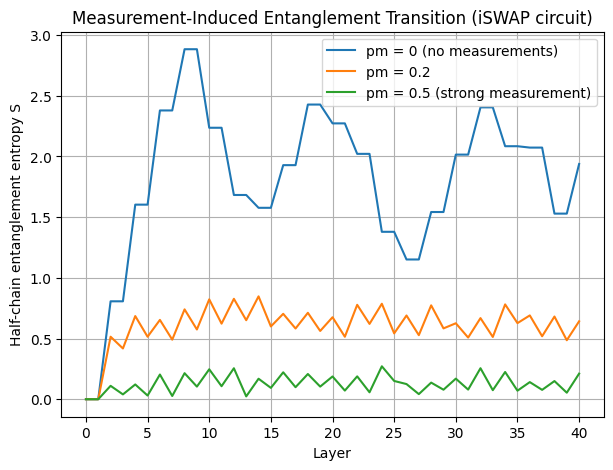

In [71]:
depth = 40
n = 8

S_pm0  = simulate_chain_entropy(n=n, depth=depth, pm=0.0, n_trajectories=50)
S_pm02 = simulate_chain_entropy(n=n, depth=depth, pm=0.2, n_trajectories=50)
S_pm05 = simulate_chain_entropy(n=n, depth=depth, pm=0.5, n_trajectories=50)

steps = np.arange(depth+1)

plt.figure(figsize=(7,5))
plt.plot(steps, S_pm0,  label="pm = 0 (no measurements)")
plt.plot(steps, S_pm02, label="pm = 0.2")
plt.plot(steps, S_pm05, label="pm = 0.5 (strong measurement)")
plt.xlabel("Layer")
plt.ylabel("Half-chain entanglement entropy S")
plt.title("Measurement-Induced Entanglement Transition (iSWAP circuit)")
plt.legend()
plt.grid(True)
plt.show()


In [111]:
# --- X-basis projectors
ketp = (np.array([1,0],complex)+np.array([0,1],complex))/np.sqrt(2)  # |+>
ketm = (np.array([1,0],complex)-np.array([0,1],complex))/np.sqrt(2)  # |->

def proj_on_qubit(n, q, ket):
    """Full-projector onto |ket> for qubit q (others = identity)."""
    Pq = np.outer(ket, ket.conj())
    ops = [I]*n
    ops[q] = Pq
    return kron(*ops)

def adaptive_X_feedback(psi, q, n):
    """
    Measure qubit q in the X basis { |+>, |-> }.
    If outcome is |->, apply Z (phase flip) to turn it into |+>.
    Return the (normalized) post-measurement state.
    """
    Pp = proj_on_qubit(n, q, ketp)
    Pm = proj_on_qubit(n, q, ketm)
    psi_p = Pp @ psi; p_p = float(np.vdot(psi_p, psi_p).real)
    psi_m = Pm @ psi; p_m = float(np.vdot(psi_m, psi_m).real)
    if p_p + p_m < 1e-15:
        return psi  # numerical fallback
    if np.random.rand() < p_p/(p_p+p_m):
        psi = psi_p/np.sqrt(max(p_p,1e-15))
        # already |+>, no correction
        return psi
    else:
        psi = psi_m/np.sqrt(max(p_m,1e-15))
        # apply Z on q to flip |-> -> |+>
        ops = [I]*n; ops[q] = Z
        return kron(*ops) @ psi

def simulate_chain_entropy_adaptive_X(n=8, depth=40, pm=0.3, n_traj=50, sticky=True, stick_prob=0.8):
    """
    Brickwork √iSWAP as before. On each layer, for each qubit:
    - with prob pm, perform X-basis measurement; if outcome |->, correct to |+>.
    If sticky=True, a qubit measured on a layer is re-measured next layer with prob stick_prob
    (mimics Zeno-like repeated monitoring).
    """
    S = np.zeros(depth+1)
    for _ in range(n_traj):
        psi = kron_state(*([ketp]*n))
        S[0] += entanglement_entropy(psi, n)
        # remember which qubits were just measured
        measured_prev = np.zeros(n, dtype=bool)
        for t in range(1, depth+1):
            psi = apply_brickwork_entangler_fast(psi, n, t)

            measured_now = np.zeros(n, dtype=bool)
            for q in range(n):
                pq = pm
                if sticky and measured_prev[q]:
                    pq = 1 - (1-pm)*(1-stick_prob)  # raise chance to re-measure
                if np.random.rand() < pq:
                    psi = adaptive_X_feedback(psi, q, n)
                    measured_now[q] = True
            measured_prev = measured_now

            S[t] += entanglement_entropy(psi, n)
    return S / n_traj


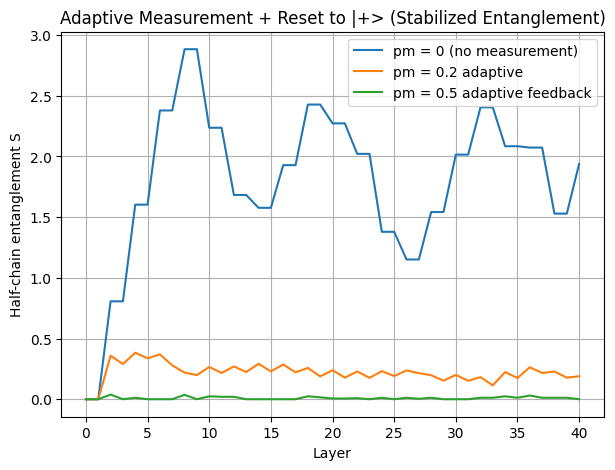

In [115]:
S_adapt_pm0  = simulate_chain_entropy_adaptive_X(n=n, depth=depth, pm=0.0, n_traj=50, sticky=True, stick_prob=0.8)
S_adapt_pm02 = simulate_chain_entropy_adaptive_X(n=n, depth=depth, pm=0.2, n_traj=50, sticky=True, stick_prob=0.8)
S_adapt_pm05 = simulate_chain_entropy_adaptive_X(n=n, depth=depth, pm=0.5, n_traj=50, sticky=True, stick_prob=0.8)
plt.figure(figsize=(7,5))
plt.plot(steps, S_adapt_pm0,  label="pm = 0 (no measurement)")
plt.plot(steps, S_adapt_pm02, label="pm = 0.2 adaptive")
plt.plot(steps, S_adapt_pm05, label="pm = 0.5 adaptive feedback")
plt.xlabel("Layer")
plt.ylabel("Half-chain entanglement S")
plt.title("Adaptive Measurement + Reset to |+> (Stabilized Entanglement)")
plt.legend()
plt.grid(True)
plt.show()


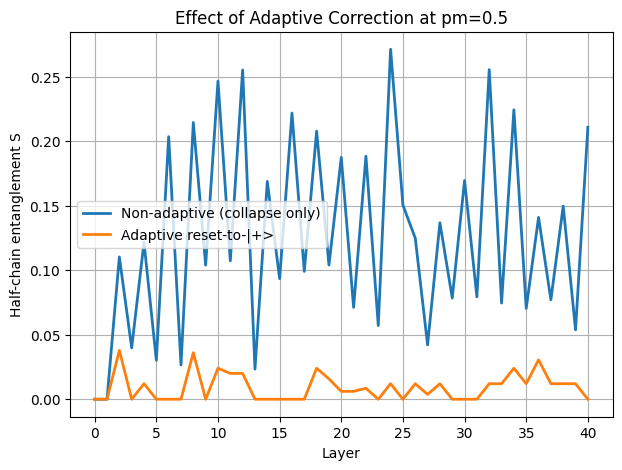

In [116]:
plt.figure(figsize=(7,5))
plt.plot(steps, S_pm05, label="Non-adaptive (collapse only)", linewidth=2)
plt.plot(steps, S_adapt_pm05, label="Adaptive reset-to-|+>", linewidth=2)
plt.xlabel("Layer")
plt.ylabel("Half-chain entanglement S")
plt.title("Effect of Adaptive Correction at pm=0.5")
plt.legend()
plt.grid(True)
plt.show()
